# Import libraries needed for the task:


In [4]:
%tensorflow_version 2.x

import os
import numpy as np
import pandas as pd
import shutil

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt

Download datasets:

In [5]:
!wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
!unzip -q flying-vehicles.zip

--2022-08-01 18:15:54--  https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.80, 172.217.0.48, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540232238 (1.4G) [application/x-zip-compressed]
Saving to: ‘flying-vehicles.zip’

flying-vehicles.zip 100%[===================>]   1.43G   163MB/s    in 11s     

2022-08-01 18:16:05 (136 MB/s) - ‘flying-vehicles.zip’ saved [1540232238/1540232238]



Prepare directories:

In [6]:
!rm -rf ./images

base_dir = './data/planes'
data_dir = './images'

raw_no_of_files = {}
classes = ['drone', 'fighter-jet', 'helicopter', 'missile', 'passenger-plane', 'rocket']
# Iterate over classes and get the size of each dataset.
for dir in classes:
    raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_no_of_files.items()


if not os.path.exists(data_dir):
    os.mkdir(data_dir)

# Training dataset
train_dir = os.path.join(data_dir, 'train')    
# Validation dataset
valid_dir = os.path.join(data_dir, 'valid')    
# Testing dataset
test_dir = os.path.join(data_dir, 'test')     

train_helicopter_dir = os.path.join(train_dir, 'helicopter')
train_missile_dir = os.path.join(train_dir, 'missile')

valid_helicopter_dir = os.path.join(valid_dir, 'helicopter')
valid_missile_dir = os.path.join(valid_dir, 'missile')

test_helicopter_dir = os.path.join(test_dir, 'helicopter')
test_missile_dir = os.path.join(test_dir, 'missile')

data_dirs = [train_helicopter_dir, train_missile_dir, valid_helicopter_dir, valid_missile_dir, test_helicopter_dir, test_missile_dir]

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

for dir in data_dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)        

Filter dataset and exclude files with extensions other that *.jpg*, *.png* or *.jpeg*:

In [7]:
helicopter_filenames = os.listdir(os.path.join(base_dir, 'helicopter'))
missile_filenames = os.listdir(os.path.join(base_dir, 'missile'))

helicopter_filenames = [filename for filename in helicopter_filenames if filename.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
missile_filenames = [filename for filename in missile_filenames if filename.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]

Calculate index of last file for each dataset:

In [8]:
size = min(len(helicopter_filenames), len(missile_filenames))

train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size


Divide files between train, validation and test datasets:

In [9]:
for i, fname in enumerate(helicopter_filenames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'helicopter', fname)
        dst = os.path.join(train_helicopter_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'helicopter', fname)
        dst = os.path.join(valid_helicopter_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'helicopter', fname)
        dst = os.path.join(test_helicopter_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(missile_filenames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'missile', fname)
        dst = os.path.join(train_missile_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'missile', fname)
        dst = os.path.join(valid_missile_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'missile', fname)
        dst = os.path.join(test_missile_dir, fname)
        shutil.copyfile(src, dst) 

print('Helicopter - training set size: ', len(os.listdir(train_helicopter_dir)))
print('Helicopter - validation set size: ', len(os.listdir(valid_helicopter_dir)))
print('Helicopter - test set size: ', len(os.listdir(test_helicopter_dir)))

print('Missile - training set size: ', len(os.listdir(train_missile_dir)))
print('Missile - validation set size: ', len(os.listdir(valid_missile_dir)))
print('Missile - test set size: ', len(os.listdir(test_missile_dir)))             

Helicopter - training set size:  921
Helicopter - validation set size:  263
Helicopter - test set size:  131
Missile - training set size:  921
Missile - validation set size:  263
Missile - test set size:  131


(-0.5, 999.5, 999.5, -0.5)

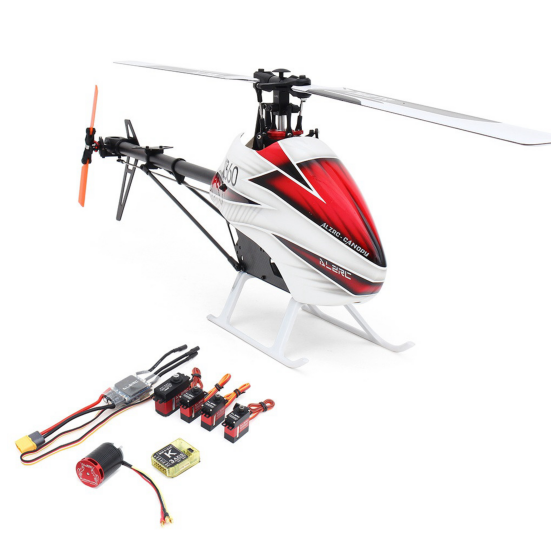

In [42]:
#@title Pick and index of an helicopter image from the training dataset:

idx = 380 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(helicopter_filenames))
img_path = os.path.join(train_helicopter_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 1259.5, 846.5, -0.5)

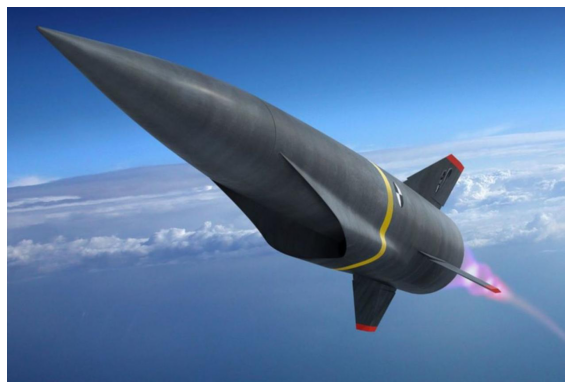

In [48]:
#@title Pick and index of an missile image from the training dataset:

idx = 239 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(missile_filenames))
img_path = os.path.join(train_missile_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

Data augmentation:

In [10]:
training_data_generator = ImageDataGenerator(
    rotation_range=40,     # the range of random rotation of an image
    rescale=1./255.,
    width_shift_range=0.2,  # the range of horizontal shift of an image
    height_shift_range=0.2, # the range of vertical shift of an image
    shear_range=0.2,        # the range of random shear of an image
    zoom_range=0.2,         # the range of random zoom of an image
    horizontal_flip=True,   # should the image be flipped horizontally
    fill_mode='nearest'     # how to deal with new pixels created during the image transformation
)

# rescale all the images by 1/255 bias.
validation_data_generator = ImageDataGenerator(rescale=1./255.)

train_generator = training_data_generator.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

valid_generator = validation_data_generator.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

Found 1842 images belonging to 2 classes.
Found 526 images belonging to 2 classes.


In [14]:
def display_augmented_images(directory, idx):
    """
    The function returns the plot with example images
    created with the data augmentation technique.
    """
    file_names = [os.path.join(directory, file_name) for file_name in os.listdir(directory)]
    img_path = file_names[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = np.expand_dims(x, 0)
    # we can also use x = x.reshape((1, ) + x.shape)
    print(x.shape)
    i = 1
    plt.figure(figsize=(16, 8))
    for batch in training_data_generator.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

(1, 150, 150, 3)


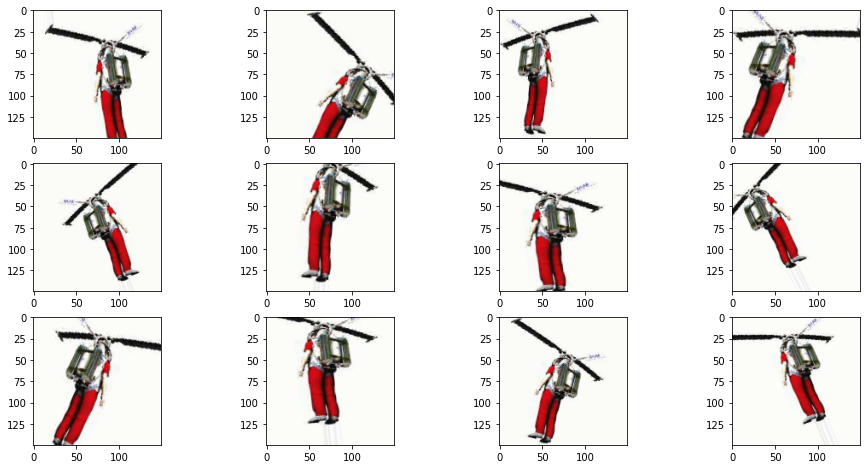

In [15]:
#@title Helicopter dataset:
idx = 467 #@param {type:'slider', min:0, max:919}            
display_augmented_images(train_helicopter_dir, idx)

Building model:

In [17]:
model = Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=1024, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

In [22]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.01),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [ ]:
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,    # 100
                             validation_data=valid_generator,
                             validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/30
28/28 [==============================] - 64s 2s/step - loss: 235.8338 - accuracy: 0.5000 - val_loss: 0.7537 - val_accuracy: 0.4883
Epoch 2/30
28/28 [==============================] - 61s 2s/step - loss: 0.7140 - accuracy: 0.4989 - val_loss: 0.7059 - val_accuracy: 0.5078
Epoch 3/30
28/28 [==============================] - 63s 2s/step - loss: 0.8504 - accuracy: 0.5458 - val_loss: 0.7047 - val_accuracy: 0.4648
Epoch 4/30
28/28 [==============================] - 61s 2s/step - loss: 45.7389 - accuracy: 0.4855 - val_loss: 0.6932 - val_accuracy: 0.4922
Epoch 5/30
28/28 [==============================] - 59s 2s/step - loss: 0.6943 - accuracy: 0.5167 - val_loss: 0.7587 - val_accuracy: 0.4922
Epoch 6/30
28/28 [==============================] - 62s 2s/step - loss: 0.7144 - accuracy: 0.4977 - val_loss: 0.6921 - val_accuracy: 0.4922
Epoch 7/30
28/28 [==============================] - 61s 2s/step - loss: 0.7178 - accuracy: 0.5261 - val_loss: 0.6921 - val_accuracy: 0.5234
Epoch 8/30
 9/28 